In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel

from scipy.spatial.distance import cdist
# from skdim.id import MLE

from tqdm import tqdm
# plt.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
## Creates pointclouds and vectorizations of persistence diagrams from the ModelNet dataset.
import sys

#import pandas as pd
from copy import deepcopy
import numpy as np
import gudhi as gd
import argparse
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
# import trimesh as trm
import glob


import tensorflow as tf
import tensorflow.keras as keras
from utils import DenseRagged, PermopRagged
from utils import sep_dist, measure_dist
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances

from tensorflow.keras.regularizers import l1, l2

import mtd
import numpy as np
from scipy.stats import entropy

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec


import seaborn as sns

# sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")

In [3]:
### Insert here path to model files in your syste,
model_path = 'Data/Models/roberta-base-cased' 
tokenizer_path = model_path

### Loading the model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
'''
Auxillary function. Clear text from linebreaks and odd whitespaces, because they seem to interfer with LM quite a lot.
Replace with a more sophisticated cleaner, if needed.
'''

def preprocess_text(text):
    return text.replace('\n', ' ').replace('  ', ' ')

In [5]:
sample_text = ["Speaking of festivities, there is one day in China that stands unrivaled - the first day of the Lunar New Year, commonly referred to as the Spring Festival. Even if you're generally uninterested in celebratory events, it's hard to resist the allure of the family reunion dinner, a quintessential aspect of the Spring Festival. Throughout the meal, family members raise their glasses to toast one another, expressing wishes for happiness, peace, health, and prosperity in the upcoming year.",
              "I am in!", "blabalbla"]

In [6]:
inputs = tokenizer(list(map(preprocess_text, sample_text)), truncation=True, max_length=512, return_tensors="pt", padding=True)
with torch.no_grad():
    outp = model(**inputs)

In [7]:
len(tokenizer(sample_text)["input_ids"])

3

In [8]:
outp[0][0].numpy()[1:-1].shape

(98, 768)

First one and last one tokens were omitted

### Let's check the data

In [9]:
# import zipfile
# path_to_zip_file = "Data/human_gpt3_davinci_003_wikip.zip"

# directory_to_extract_to = "Data/texts_datsets/"
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [10]:
wiki_data = pd.read_json("Data/texts_datsets/human_gpt3_davinci_003_wikip.json_pp", lines=True)

In [11]:
print("Prefix: ", wiki_data[0][0]["prefix"], "\n")
print("Human text: ", wiki_data[0][0]["gold_completion"], "\n")
print("GPT text: ", wiki_data[0][0]["gen_completion"])

Prefix:  One tank tumbled down an embankment into the Tenaru River, drowning its crew. At 23:00 on 14 September, the remnants of the Kuma battalion conducted another attack on the same portion of the Marine lines, but were repulsed. 

Human text:  A final "weak" attack by the Kuma unit on the evening of 15 September was also defeated. Oka's unit of about 650 men attacked the Marines at several locations on the west side of the Lunga perimeter. At about 04:00 on 14 September, two Japanese companies attacked positions held by the 3rd Battalion, 5th Marine Regiment (3/5) near the coast and were thrown back with heavy losses. Another Japanese company captured a small ridge somewhat inland but was then pinned down by Marine artillery fire throughout the day and took heavy losses before withdrawing on the evening of 14 September. The rest of Oka's unit failed to find the Marine lines and did not participate in the attack. At 13:05 on 14 September, Kawaguchi led the survivors of his shattered

In [12]:
inputs = tokenizer(preprocess_text(wiki_data[0][0]["gold_completion"]), truncation=True, max_length=512, return_tensors="pt")
with torch.no_grad():
    outp = model(**inputs)

In [13]:
human = outp[0][0].numpy()[1:-1]
print(human.shape)

(444, 768)


In [14]:
inputs = tokenizer(preprocess_text(wiki_data[0][0]["gen_completion"]), truncation=True, max_length=512, return_tensors="pt")
with torch.no_grad():
    outp = model(**inputs)

In [15]:
gpt = outp[0][0].numpy()[1:-1]
print(gpt.shape)

(88, 768)


In [16]:
d_inp = gpt.shape[1]

---

### Make dataset

In [17]:
number_promts = 50
labels = []
text_data = []

for i in range(number_promts):
    labels.append("human")
    text_data.append(wiki_data[i][0]["gold_completion"])

    labels.append("gpt")
    text_data.append(wiki_data[i][0]["gen_completion"])

In [18]:
len(text_data)

100

In [19]:
buffer = np.array([[i, j] for i in np.arange(len(text_data)) for j in np.arange(len(text_data))])
# buffer_id =  np.random.choice(len(buffer), 2500, replace = False)
train_indexes = buffer

### Tokenize and then embed

In [20]:
pc_train = []
for text_sample in tqdm(text_data):
    inputs = tokenizer(preprocess_text(text_sample), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)
        
    pc_train.append(outp[0][0].numpy()[1:-1])

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


In [22]:
import pickle
with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_text_data", "wb") as fp:   #Pickling
    pickle.dump(text_data, fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_pc_train", "wb") as fp:   #Pickling
    pickle.dump(pc_train, fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_train_indexes", "wb") as fp:   #Pickling
    pickle.dump(train_indexes, fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_labels", "wb") as fp:   #Pickling
    pickle.dump(labels, fp)

---

### Calculate PD

In [93]:
n_boostrap = 50
batch_size_portion2 = 0.8
batch_size_portion1 = 0.6
train_PD = []
for i,j in tqdm(train_indexes):  
    batch_size1 = int(len(pc_train[i]) * batch_size_portion1)
    batch_size2 = int(len(pc_train[i]) * batch_size_portion2)
    barc = [mtd.calc_cross_barcodes(pc_train[i], pc_train[j], batch_size1 = batch_size1, batch_size2 = batch_size2, is_plot = False, pdist_device = "cuda") for _ in range(n_boostrap)]
    train_PD.append(barc)

 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5865/10000 [5:58:03<8:37:53,  7.51s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [3]:
import pickle
# with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_pds_10000_50_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(train_PD, fp)

with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_pds_10000_50_boostrap", 'rb') as fp:   #Pickling
    train_PD = pickle.load(fp)

In [4]:
train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

train_PD_0 = [[x[0] if len(x[0])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

In [5]:
from gudhi.representations import DiagramSelector
pds_train = DiagramSelector(use=True).fit_transform(train_PD_1[0])
vpdtr = np.vstack(pds_train)

for barcs in tqdm(train_PD_1[1:500]):
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
# bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
# ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
# sigma = np.quantile(ppers, .2) ### доработать подбор bandwidth константы
# im_bnds = [np.quantile(vpdtr[:,0],0.0001), np.quantile(vpdtr[:,0],0.999), np.quantile(pers,0.001), np.quantile(pers,0.999)]
im_bnds = [np.min(vpdtr[:,0]), np.max(vpdtr[:,0]), np.min(pers), np.max(pers)]

100%|█████████████████████████████████████████| 499/499 [00:16<00:00, 31.16it/s]


# What about (x,y)->(x, y-x) transformation ???

In [ ]:
### Base transformation y-axis to persistence

# for barcs in train_PD_1:
#     for barc in barcs:
#         barc[:, 1] = barc[:, 1]- barc[:, 0]

In [9]:
n_boostrap = 50

In [10]:
# from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_train_all = []
for barcs in tqdm(train_PD_1):
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    pds_train = [item.astype(np.float32) for item in pds_train]
    # clean_pds_test = DiagramSelector(use=True).fit_transform(train_PD_1[800:])
    
    
    vpdtr = np.vstack(pds_train)
    pers = vpdtr[:,1]-vpdtr[:,0]
    bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
    ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    sigma = np.quantile(ppers, .01)
    
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1]**2, 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
    # clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
    PI_train = np.sum(PI_train,axis = 0)/n_boostrap
    PI_train = PI_train/np.sum(PI_train)
    PI_train_all.append(PI_train)
    
PI_train_all = np.array(PI_train_all)

100%|███████████████████████████████████| 10000/10000 [1:05:31<00:00,  2.54it/s]


In [13]:
import pickle
# with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_PI_10000_50_boostrap", "wb") as fp:   #Pickling
#     pickle.dump(PI_train_all, fp)

# with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_PI_10000_50_boostrap", 'rb') as fp:   #Pickling
#     PI_train_all = pickle.load(fp)

In [14]:
PI_train_all.shape

(10000, 2500)

In [51]:
PI_train = np.vstack([PI_train_all[:2000]])
clean_PI_test = np.vstack([PI_train_all[2000:2500]])

In [39]:
# PI_train = np.vstack(PI_train_all)

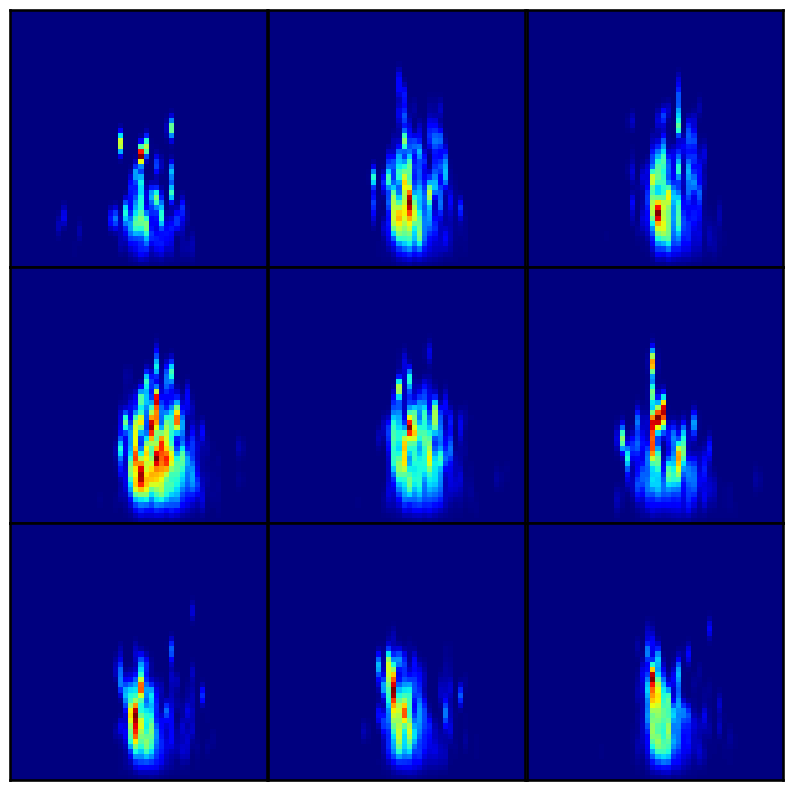

In [40]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(PI_train_all[600*i+3*j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

In [65]:
from scipy.stats import entropy

def sym_KL(y_true, y_pred):
    loss = tf.keras.losses.KLDivergence()
    return (loss(y_true, y_pred) + loss(y_pred, y_true))/2

In [66]:
n_components = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=150, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)

optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs_1 = tf.keras.Input(shape=(None, n_components), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None, n_components), dtype ="float32", ragged=True)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)
## Добавить расстояния как фичи


z = keras.layers.Concatenate(axis=-1)([x, y, x_y])

z = tf.keras.layers.Dense(100,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(0.1)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1,inputs_2], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

### Let's compress data

In [43]:
from sklearn.decomposition import PCA
PCA = PCA(n_components=n_components)
features = [PCA.fit_transform(cloud) for cloud in pc_train]

In [44]:
# data_train_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[:8000]])
# data_test_concat = np.array([np.vstack((pc_train[i],pc_train[j])) for i,j in train_indexes[8000:]])


tf_data_train_1 = tf.ragged.constant([
    features[i] for i in train_indexes[:2000][:,0]], ragged_rank=1)
print("done 1")
tf_data_train_2 = tf.ragged.constant([
    features[i] for i in train_indexes[:2000][:,1]], ragged_rank=1)
print("done 2")


tf_data_test_1 = tf.ragged.constant([
    features[i] for i in train_indexes[2000:2500][:,0]], ragged_rank=1)
print("done 3")
tf_data_test_2 = tf.ragged.constant([
    features[i] for i in train_indexes[2000:2500][:,1]], ragged_rank=1)

done 1
done 2
done 3


In [71]:
history = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2], PI_train, epochs=1000, 
                       validation_data=([tf_data_test_1, tf_data_test_2], clean_PI_test), callbacks=[callback], verbose=1)

Epoch 1/1000
63/63 [==============================] - 2s 28ms/step - loss: 9.7715 - val_loss: 5.1337
Epoch 2/1000
63/63 [==============================] - 1s 23ms/step - loss: 3.0684 - val_loss: 2.1754
Epoch 3/1000
63/63 [==============================] - 1s 21ms/step - loss: 1.5166 - val_loss: 1.3546
Epoch 4/1000
63/63 [==============================] - 1s 19ms/step - loss: 1.0569 - val_loss: 1.1298
Epoch 5/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.9030 - val_loss: 1.0865
Epoch 6/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.8340 - val_loss: 1.0504
Epoch 7/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.7941 - val_loss: 1.0082
Epoch 8/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.7636 - val_loss: 0.9981
Epoch 9/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.7417 - val_loss: 0.9749
Epoch 10/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.7236 - val_lo

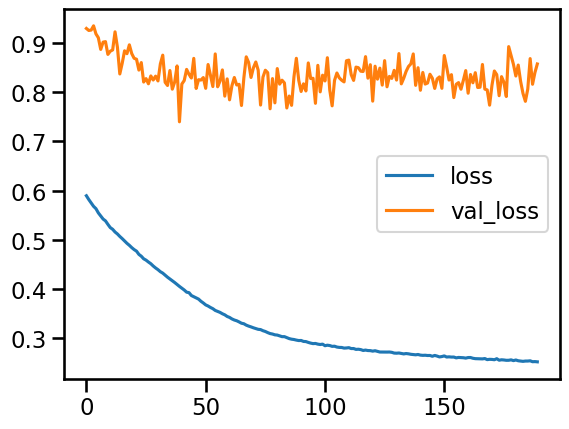

In [72]:
plt.plot(np.array(history.history["loss"][20:]))
plt.plot(np.array(history.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.show()

In [73]:
train_PI_prediction = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2])
clean_PI_prediction = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2])

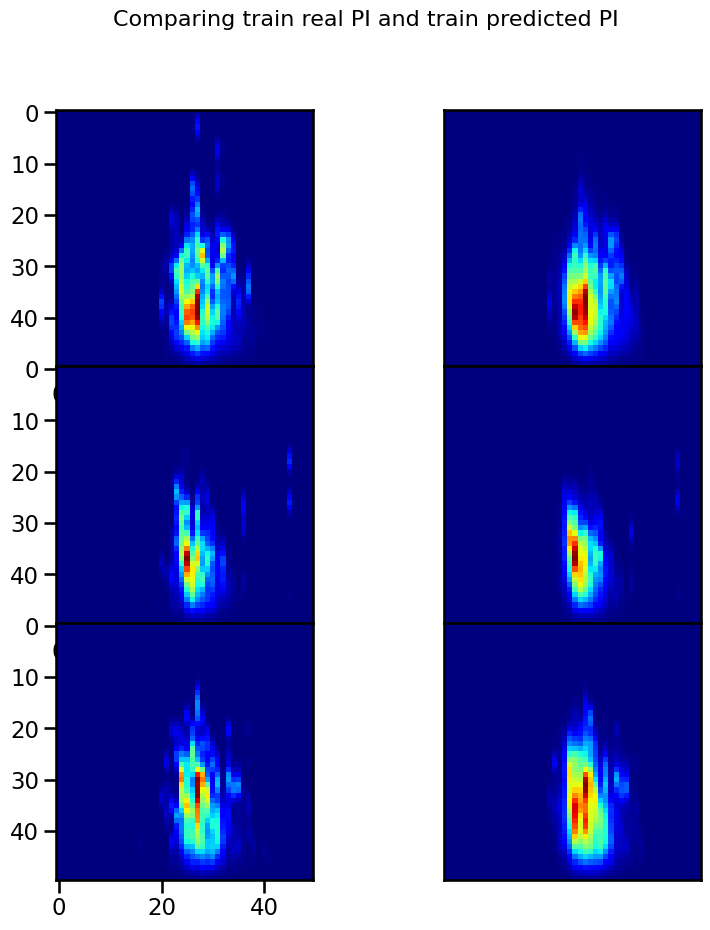

In [74]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[200*i+1], [50,50]), 0), cmap='jet')

    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

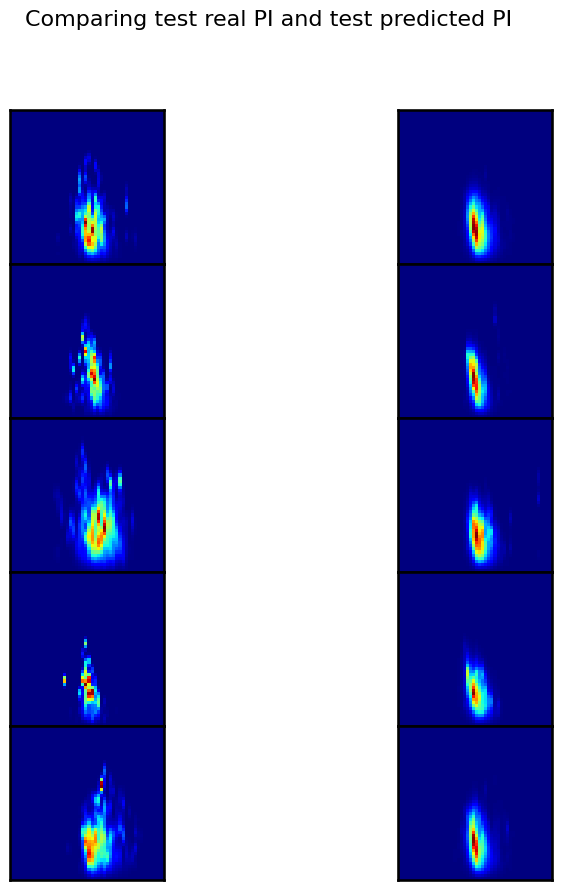

In [75]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Comparing test real PI and test predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test[100*i+i], [50,50]), 0), cmap='jet',)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    # ax.set_title(f"{labels[train_indexes[100*i][0]]} vs {labels[train_indexes[100*i][1]]}")
    ax.imshow(np.flip(np.reshape(clean_PI_prediction[100*i+i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

### Let's look closely to Persistece Images 

In [76]:
train_indexes[100:110]

array([[1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7],
       [1, 8],
       [1, 9]])

In [77]:
gpt_gpt = list(range(101,112,2))
gpt_human = list(range(100,112,2))

In [78]:
gpt_gpt

[101, 103, 105, 107, 109, 111]

In [79]:
gpt_human

[100, 102, 104, 106, 108, 110]

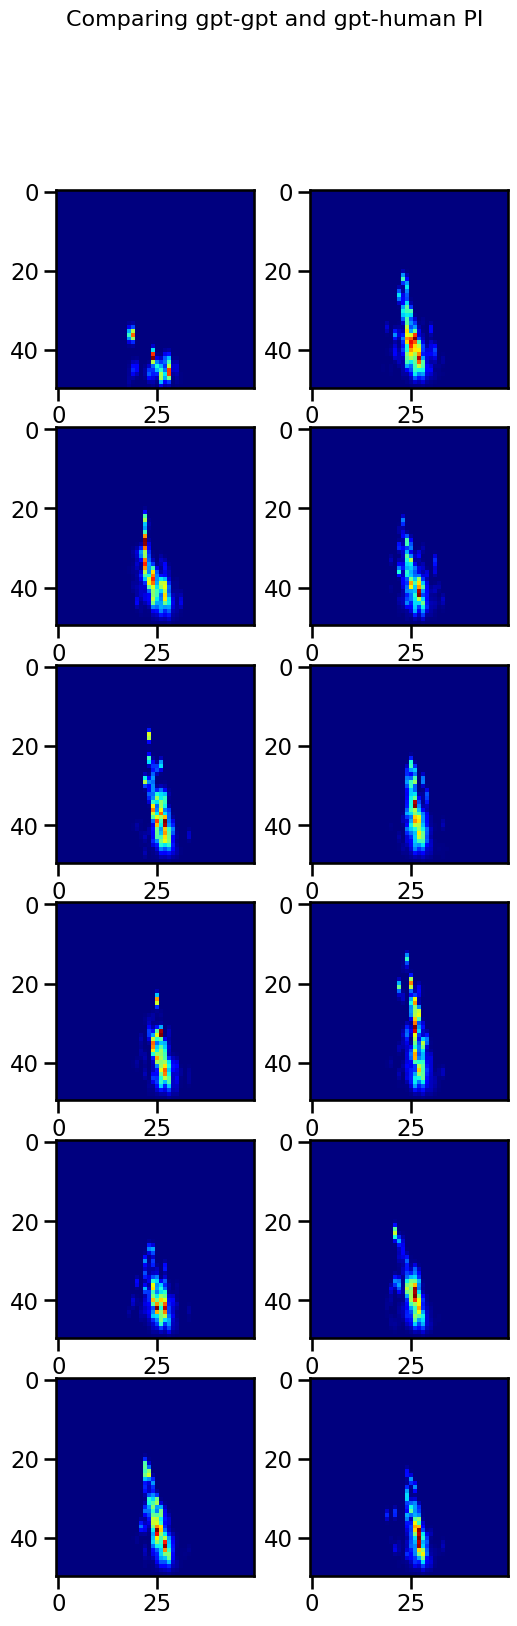

In [80]:
f, axs = plt.subplots(6, 2, figsize=(6, 18))
f.suptitle(f"Comparing gpt-gpt and gpt-human PI", fontsize=16)

for i in range(len(gpt_gpt)):
    axs[i,0].imshow(np.flip(np.reshape(PI_train[gpt_gpt[i]], [50,50]), 0), cmap='jet',)

    axs[i,1].imshow(np.flip(np.reshape(PI_train[gpt_human[i]], [50,50]), 0), cmap='jet',)

---

In the paper dedicated to the intrinsic dimension of text embeddings,it was said that zero-dimensional features much more informative in this case than one-dimensional features. Considering that, we now want to use CrossRipsNet to predict not a 2d density, but the 1d lenght of cross-barcode. As all zero-dimensional features appear at the start time only.

In [99]:
from gudhi.representations import DiagramSelector
pds_train = DiagramSelector(use=True).fit_transform(train_PD_0[0])
vpdtr = np.vstack(pds_train)

for barcs in tqdm(train_PD_0[1:500]):
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
# bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
# ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
# sigma = np.quantile(ppers, .2) ### доработать подбор bandwidth константы
im_bnds = [np.min(vpdtr[:,0]),0.3, np.min(pers), np.max(pers)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:19<00:00, 25.17it/s]


In [100]:
im_bnds

[0.0, 0.3, 9.664502613304649e-06, 13.822723388671875]

In [104]:
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_train_all_0 = []
for barcs in tqdm(train_PD_0):
    barcs = [a.astype(float) for a in barcs]
    pds_train = DiagramSelector(use=True).fit_transform(barcs)


    vpdtr = np.vstack(pds_train)
    pers = vpdtr[:,1]-vpdtr[:,0]
    bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
    ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    sigma = np.quantile(ppers, .02)
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
    PI_train = np.sum(PI_train,axis = 0)/n_boostrap
    PI_train = PI_train/np.sum(PI_train)
    PI_train_all_0.append(PI_train)
    
PI_train_all_0 = np.array(PI_train_all_0)

 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                     | 4749/10000 [53:46<46:34,  1.88it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [105]:
import pickle
with open("Data/cross_ripsnet_text_exp/human_gpt3_davinci_003_PI_zero_10000_50_boostrap", "wb") as fp:   #Pickling
    pickle.dump(PI_train_all_0, fp)

In [106]:
PI_train_0 = np.vstack([PI_train_all_0[:2000]])
clean_PI_test_0 = np.vstack([PI_train_all_0[2000:2500]])

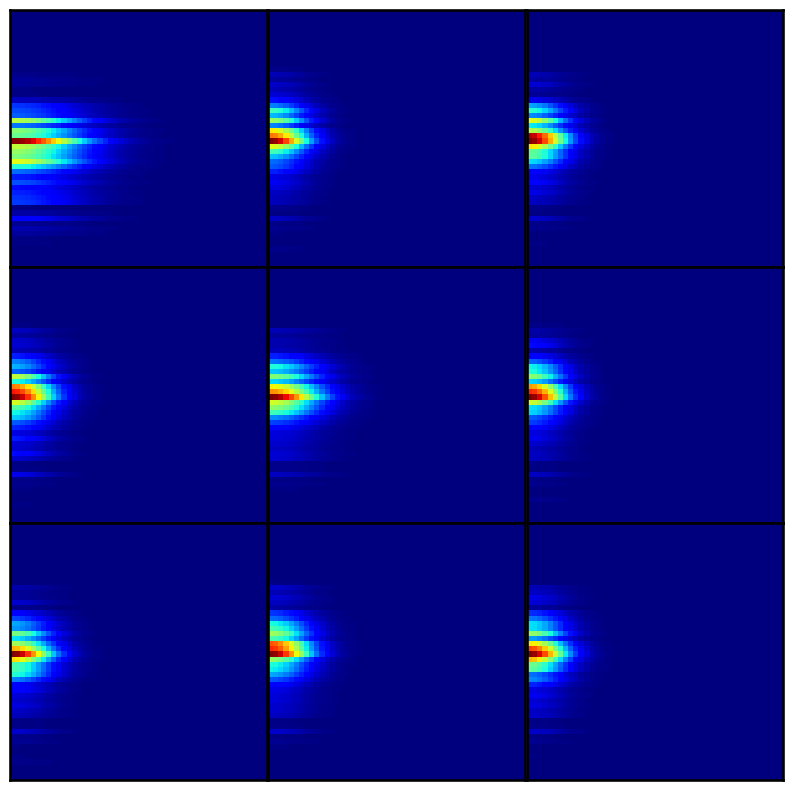

In [107]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(PI_train_all_0[i+3*j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

In [108]:
from MTopDiv.mtd.barcodes import plot_barcodes

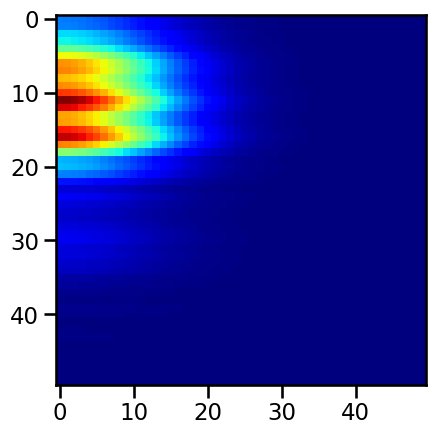

In [109]:
idx = 1000
im_bnds = [0,0.5,0,9]

# a = np.array([[[0,0],[0,1],[0,2]]])
a = train_PD_0[idx]
a = DiagramSelector(use=True).fit_transform(a)

vpdtr = np.vstack(a)
pers = vpdtr[:,1]-vpdtr[:,0]
sigma = np.quantile(ppers, .04)

PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}

a = PersistenceImage(**PI_params).fit_transform(a)
a = np.sum(a,axis = 0)/n_boostrap
a = a/np.sum(a)
plt.imshow(np.flip(np.reshape(a, [50,50]), 0), cmap='jet')

295
max0,976Barcode 0 = 9.247086
maxBarcode 0 = 9.859031
middleBarcode 0 = 6.7305064
202
max0,976Barcode 1 = 1.1210041
maxBarcode 1 = 1.4516497
middleBarcode 1 = 0.28196335


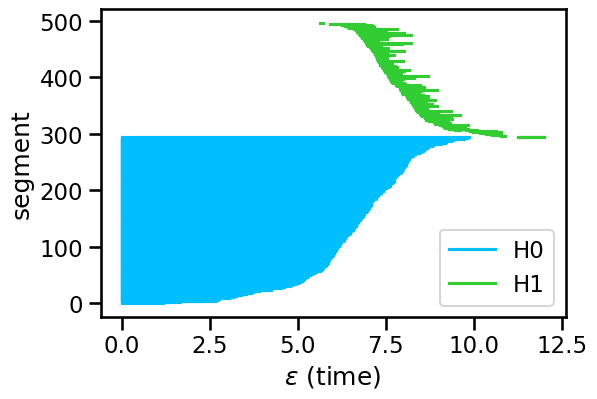

In [146]:
plot_barcodes(np.array(train_PD[idx][0], dtype=object))

Нужно контролировать параметр сигма!

---

In [123]:
n_components = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=100, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)
dropout_rate = 0.2
optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs_1 = tf.keras.Input(shape=(None, n_components), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None, n_components), dtype ="float32", ragged=True)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)
## Добавить расстояния как фичи


z = keras.layers.Concatenate(axis=-1)([x, y, x_y])

z = tf.keras.layers.Dense(100,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
outputs = tf.keras.layers.Dense(PI_train_0.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1,inputs_2], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

In [124]:
history = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2], PI_train_0, epochs=1000, 
                       validation_data=([tf_data_test_1, tf_data_test_2], clean_PI_test_0), callbacks=[callback], verbose=1)

Epoch 1/1000
63/63 [==============================] - 4s 26ms/step - loss: 68.0586 - val_loss: 27.0520
Epoch 2/1000
63/63 [==============================] - 1s 15ms/step - loss: 14.3726 - val_loss: 8.7523
Epoch 3/1000
63/63 [==============================] - 1s 13ms/step - loss: 4.3998 - val_loss: 2.3168
Epoch 4/1000
63/63 [==============================] - 1s 15ms/step - loss: 1.2419 - val_loss: 0.8504
Epoch 5/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.5978 - val_loss: 0.5888
Epoch 6/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.4591 - val_loss: 0.5187
Epoch 7/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.4047 - val_loss: 0.4602
Epoch 8/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.3761 - val_loss: 0.4546
Epoch 9/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.3587 - val_loss: 0.4313
Epoch 10/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.3452 - val

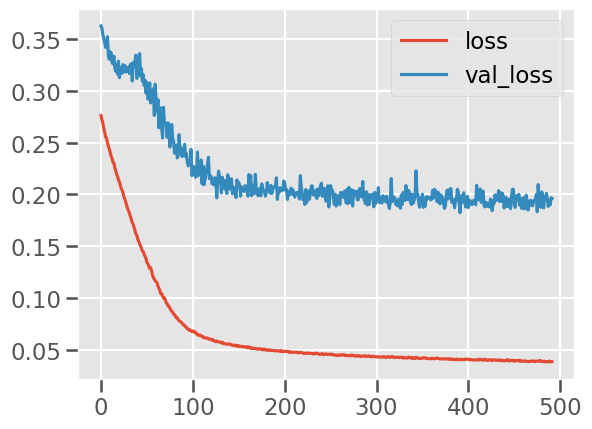

In [125]:
plt.plot(np.array(history.history["loss"][20:]))
plt.plot(np.array(history.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.show()

In [126]:
train_PI_prediction_0 = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2])
clean_PI_prediction_0 = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2])

---

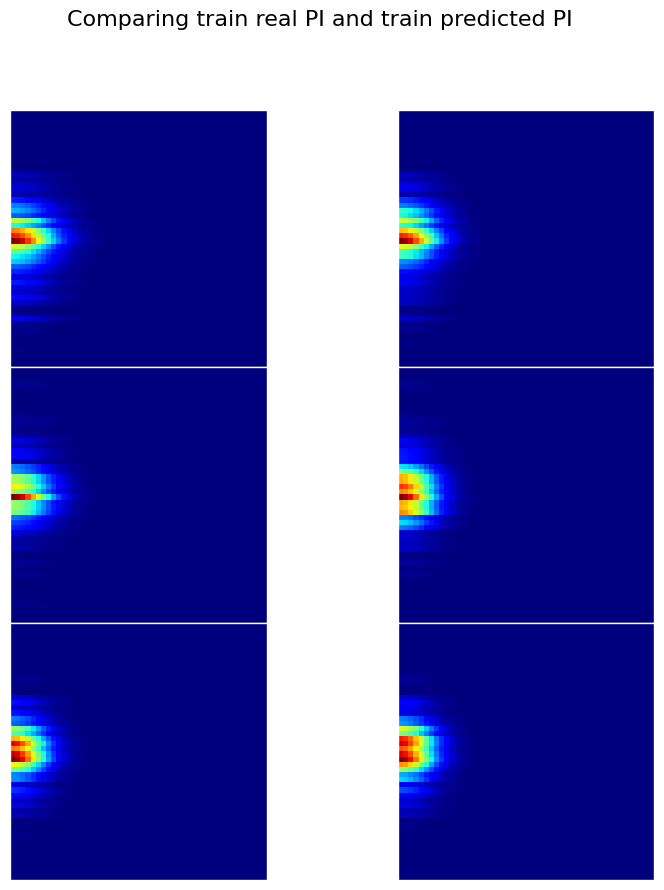

In [127]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train_0[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_0[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

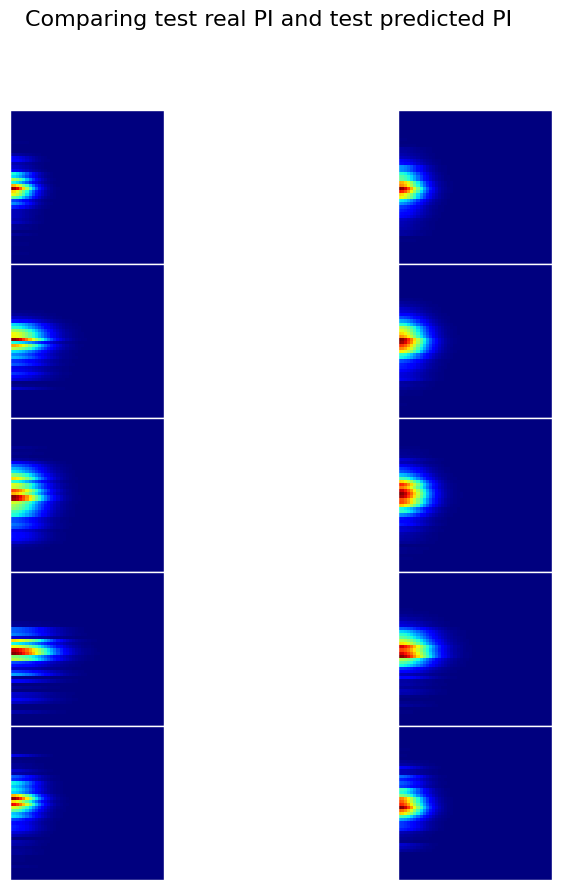

In [128]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Comparing test real PI and test predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test_0[100*i+i], [50,50]), 0), cmap='jet',)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    # ax.set_title(f"{labels[train_indexes[100*i][0]]} vs {labels[train_indexes[100*i][1]]}")
    ax.imshow(np.flip(np.reshape(clean_PI_prediction_0[100*i+i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])